In [17]:
import numpy as np
class Environment():
  def __init__(self,n_arms, probabilities) :
    self.n_arms = n_arms
    self.probabilities = probabilities 

  def round(self, pulled_arm) :
   reward = np.random.binomial(1,self.probabilities[pulled_arm])      
   return reward

In [18]:
class Learner:

  def __init__(self, n_arms) :
    self.n_arms = n_arms
    self.t = 0
    self.rewards_per_arm = x = [[] for i in range(n_arms)]
    self.collected_rewards = np.array([])

  def update_observations(self,pulled_arm, reward) :
    self.rewards_per_arm[pulled_arm].append(reward)
    self.collected_rewards = np.append(self.collected_rewards, reward)

In [33]:
class Environment_PBM(Environment):
  def __init__(self, n_arms, n_positions, arm_probabilities, position_probabilities):
    self.n_arms = n_arms
    self.n_positions = n_positions
    self.arm_probabilities = arm_probabilities
    self.position_probabilities = position_probabilities
    assert n_positions == len(position_probabilities)
    assert n_arms == len(arm_probabilities)

  def round(self, super_arm):
    assert len(super_arm) == self.n_positions
    position_obs = np.random.binomial(1, self.position_probabilities)
    arm_probabilities = np. random.binomial(1, self.arm_probabilities[super_arm])
    return arm_probabilities*position_obs



In [37]:
import numpy as np


class PBM_UCB(Learner):
  def __init__(self, n_arms, n_positions, position_probabilities, delta):
    super().__init__(n_arms)
    self.position_probabilities = position_probabilities
    self.n_arms = n_arms
    self.n_positions = n_positions
    assert n_positions == len(self.position_probabilities)
    self.S_kl = np.zeros((n_arms, n_positions))
    self.S_k = np.zeros(n_arms)
    self.N_kl = np.zeros((n_arms, n_positions))
    self.N_k = np.zeros(n_arms)
    self.tilde_N_kl = np.zeros((n_arms, n_positions))
    self.tilde_N_k = np.zeros(n_arms)
    self.delta = delta
    self.empirical_means = np.zeros(n_arms)
    self.confidence = np.array([np.inf]*n_arms)

  def pull_arm(self):
    upper_conf = self.empirical_means + self.confidence
    return np.argsort(upper_conf)[::-1][:self.n_positions]

  def update(self, super_arm, reward):
    self.t += 1
    for pos, arm in enumerate(super_arm):
      self.S_kl[arm, pos] += reward[pos]
      self.N_kl[arm, pos] += 1
      self.tilde_N_kl[arm, pos] += self.position_probabilities[pos]
    
    self.S_k = self.S_kl.sum(axis=1)
    self.N_k = self.N_kl.sum(axis=1)
    self.tilde_N_k = self.tilde_N_kl.sum(axis=1)

    self.empirical_means = self.S_k/self.tilde_N_k
    self.confidence = np.sqrt(self.N_k/self.tilde_N_k)*np.sqrt(self.delta/(2*self.tilde_N_k))
    self.empirical_means[self.N_k == 0] = np.inf
    self.confidence[self.tilde_N_k == 0] = np.inf
    self.update_observations(super_arm, reward)


  def update_observations(self, pulled_arm, reward):
    self.collected_rewards = np.append(self.collected_rewards, reward.sum())



In [31]:
import numpy as np
import scipy.stats
import scipy.special as sc


class PBM_TS(Learner):
  def __init__(self, n_arms, n_positions, position_probabilities, M=10):
    super().__init__(n_arms)
    self.position_probabilities = position_probabilities
    self.n_arms = n_arms
    self.n_positions = n_positions
    assert n_positions == len(self.position_probabilities)
    self.S_kl = np.zeros((n_arms, n_positions))
    self.S_k = np.zeros(n_arms)
    self.N_kl = np.zeros((n_arms, n_positions))
    self.N_k = np.zeros(n_arms)
    self.tilde_N_kl = np.zeros((n_arms, n_positions))
    self.tilde_N_k = np.zeros(n_arms)
    self.M = M
    self.beta_parameters = np.ones((n_arms, 2))


  def _beta_pdf(self, arm, theta):
    a = self.beta_parameters[arm, 0]
    b = self. beta_parameters[arm, 1]
    return scipy.stats.beta.pdf(theta, a, b)


  def _real_pdf(self, arm, theta):
    p = 0
    for pos in range(self.n_positions):
      pos_prob = self.position_probabilities[pos]
      a = self.S_kl[arm, pos]
      b = self.N_kl[arm,pos] - self.S_kl[arm,pos]
      p += sc.xlog1py(b, -theta*pos_prob) + sc.xlogy(a, theta)
      p -= sc.betaln(a, b)
      p += a*np.log(pos_prob)
    return np.exp(p)

  def _rejection_sample(self, arm):
    count = 0
    while count <self.M:
      count += 1
      theta = np. random.beta(self.beta_parameters[arm, 0], self.beta_parameters[arm, 1])
      u = np.random.uniform()
      if u*self._beta_pdf(arm, theta) < self._real_pdf(arm, theta):
        return theta
      return theta
    
  def pull_arm(self):
    samples = np.array([self._rejection_sample(k) for k in range(self.n_arms)])
    return np.argsort(samples)[::-1][:self.n_positions]

  def update(self, super_arm, reward):
    self.t += 1
    for pos, arm in enumerate(super_arm):
      self.S_kl[arm,pos] += reward[pos]
      self.tilde_N_kl[arm, pos] += self.position_probabilities[pos]
      self.N_kl[arm,pos] += 1

    self.S_k = self.S_kl.sum(axis=1)
    self.N_k = self.N_kl.sum(axis=1)
    self.tilde_N_k = self.tilde_N_kl.sum(axis=1)

    for arm in super_arm:
      pos = np.argmax(self.tilde_N_kl[arm, :])
      self.beta_parameters[arm, 0] = max(self.S_kl[arm, pos] + 1, 1)
      self.beta_parameters[arm, 1] = max(self.tilde_N_kl[arm, pos] - self.S_kl[arm, pos] + 1, 1)

    self.update_observations(super_arm, reward)

  def update_observations(self, pulled_arm, reward):
      self.collected_rewards = np.append(self.collected_rewards, reward.sum())

    

0.69
0


  0%|          | 0/3000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide


1


  0%|          | 0/3000 [00:00<?, ?it/s]

2


  0%|          | 0/3000 [00:00<?, ?it/s]

3


  0%|          | 0/3000 [00:00<?, ?it/s]

4


  0%|          | 0/3000 [00:00<?, ?it/s]

5


  0%|          | 0/3000 [00:00<?, ?it/s]

6


  0%|          | 0/3000 [00:00<?, ?it/s]

7


  0%|          | 0/3000 [00:00<?, ?it/s]

8


  0%|          | 0/3000 [00:00<?, ?it/s]

9


  0%|          | 0/3000 [00:00<?, ?it/s]

10


  0%|          | 0/3000 [00:00<?, ?it/s]

11


  0%|          | 0/3000 [00:00<?, ?it/s]

12


  0%|          | 0/3000 [00:00<?, ?it/s]

13


  0%|          | 0/3000 [00:00<?, ?it/s]

14


  0%|          | 0/3000 [00:00<?, ?it/s]

15


  0%|          | 0/3000 [00:00<?, ?it/s]

16


  0%|          | 0/3000 [00:00<?, ?it/s]

17


  0%|          | 0/3000 [00:00<?, ?it/s]

18


  0%|          | 0/3000 [00:00<?, ?it/s]

19


  0%|          | 0/3000 [00:00<?, ?it/s]

20


  0%|          | 0/3000 [00:00<?, ?it/s]

21


  0%|          | 0/3000 [00:00<?, ?it/s]

22


  0%|          | 0/3000 [00:00<?, ?it/s]

23


  0%|          | 0/3000 [00:00<?, ?it/s]

24


  0%|          | 0/3000 [00:00<?, ?it/s]

25


  0%|          | 0/3000 [00:00<?, ?it/s]

26


  0%|          | 0/3000 [00:00<?, ?it/s]

27


  0%|          | 0/3000 [00:00<?, ?it/s]

28


  0%|          | 0/3000 [00:00<?, ?it/s]

29


  0%|          | 0/3000 [00:00<?, ?it/s]

30


  0%|          | 0/3000 [00:00<?, ?it/s]

31


  0%|          | 0/3000 [00:00<?, ?it/s]

32


  0%|          | 0/3000 [00:00<?, ?it/s]

33


  0%|          | 0/3000 [00:00<?, ?it/s]

34


  0%|          | 0/3000 [00:00<?, ?it/s]

35


  0%|          | 0/3000 [00:00<?, ?it/s]

36


  0%|          | 0/3000 [00:00<?, ?it/s]

37


  0%|          | 0/3000 [00:00<?, ?it/s]

38


  0%|          | 0/3000 [00:00<?, ?it/s]

39


  0%|          | 0/3000 [00:00<?, ?it/s]

40


  0%|          | 0/3000 [00:00<?, ?it/s]

41


  0%|          | 0/3000 [00:00<?, ?it/s]

42


  0%|          | 0/3000 [00:00<?, ?it/s]

43


  0%|          | 0/3000 [00:00<?, ?it/s]

44


  0%|          | 0/3000 [00:00<?, ?it/s]

45


  0%|          | 0/3000 [00:00<?, ?it/s]

46


  0%|          | 0/3000 [00:00<?, ?it/s]

47


  0%|          | 0/3000 [00:00<?, ?it/s]

48


  0%|          | 0/3000 [00:00<?, ?it/s]

49


  0%|          | 0/3000 [00:00<?, ?it/s]

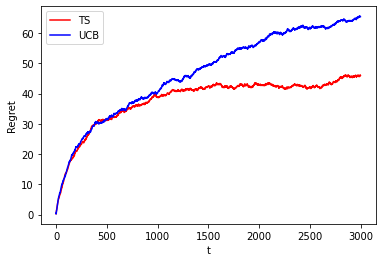

In [40]:
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm


if __name__ == '__main__':
  arm_probabilities = np.array([0.45, 0.35, 0.25, 0.15, 0.05])
  position_probabilities = np.array([0.9, 0.6, 0.3])
  n_pos = 3
  n_arms = 5

  T = 3000
  opt = (np.sort(arm_probabilities)[::-1][:n_pos]*position_probabilities).sum()
  print(opt)

  n_experiments = 50
  ts_rewards_per_experiment = []
  ucb_reward_per_experiment = []


  for e in range(n_experiments):
    print(e)
    env = Environment_PBM(n_arms=n_arms, n_positions=3, arm_probabilities=arm_probabilities, position_probabilities=position_probabilities)
    ts_learner = PBM_TS(n_arms, n_pos, np.array([0.9, 0.6, 0.3]), M=10)
    ucb_learner = PBM_UCB(n_arms, n_pos, np.array([0.9,0.6,0.3]), delta=10)
    for t in tqdm(range(T)):
      #Thompson sampling learner
      pulled_arm = ts_learner.pull_arm()
      reward = env.round(pulled_arm)
      ts_learner.update(pulled_arm, reward)

      #UCB learner
      pulled_arm = ucb_learner.pull_arm()
      reward = env.round(pulled_arm)
      ucb_learner.update(pulled_arm, reward)
    ts_rewards_per_experiment.append(ts_learner.collected_rewards)
    ucb_reward_per_experiment.append(ucb_learner.collected_rewards)


  plt.figure(0)
  plt.ylabel("Regret")
  plt.xlabel("t")
  plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis=0)), 'r')
  plt.plot(np.cumsum(np.mean(opt - ucb_reward_per_experiment, axis=0)), 'b') 
  plt.legend(["TS", "UCB"])
  plt.show()      